## Introduction
In this notebook we will train the 3D Unet to segment the liver and liver tumors in CT scans

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

* pathlib for easy path handling
* HTML for visualizing volume videos
* torchio for dataset creation
* torch for DataLoaders, optimizer and loss
* pytorch-lightning for training
* numpy for masking
* matplotlib for visualization
* Our 3D model

In [ ]:
!pip install torchio
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 172 kB 5.0 MB/s 
     |████████████████████████████████| 52.8 MB 251 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 706 kB 5.2 MB/s 
     |████████████████████████████████| 5.9 MB 63.3 MB/s 
     |████████████████████████████████| 419 kB 70.6 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [ ]:
%cd  '/content/drive/My Drive/pytorch_udemy/08-3D-Liver-Tumor-Segmentation/'

/content/drive/My Drive/pytorch_udemy/08-3D-Liver-Tumor-Segmentation


In [ ]:
from pathlib import Path

import torchio as tio
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
from model import UNet

## Dataset Creation
We can loop over all available scans and add them to the subject list

In [ ]:
def change_img_to_label_path(path):
    """
    Replace data with mask to get the masks
    """
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)


In [ ]:
path = Path("Task03_Liver_rs/imagesTr/")
subjects_paths = list(path.glob("liver_*"))
subjects = []

for subject_path in subjects_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"CT":tio.ScalarImage(subject_path), "Label":tio.LabelMap(label_path)})
    subjects.append(subject)


In [ ]:
for subject in subjects:
    assert subject["CT"].orientation == ("R", "A", "S")

We use the same  augmentation steps as used in the Dataset notebook. <br />
Regarding the processing, we use the **CropOrPad** functionality which crops or pads all images and masks to the same shape. <br />

We use ($256 \times 256 \times 200$)

In [ ]:
process = tio.Compose([
            tio.CropOrPad((256, 256, 200)),
            tio.RescaleIntensity((-1, 1))
            ])


augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))


val_transform = process
train_transform = tio.Compose([process, augmentation])

Define the train and validation dataset. We use 105 subjects for training and 13 for testing. <br />
In order to help the segmentation network learn, we use the LabelSampler with p=0.2 for background, p=0.3 for liver and p=0.5 for liver tumors with a patch size of ($96 \times 96 \times 96$).

Feel free to try the UniformSampler

In [ ]:
train_dataset = tio.SubjectsDataset(subjects[:105], transform=train_transform)
val_dataset = tio.SubjectsDataset(subjects[105:], transform=val_transform)

sampler = tio.data.LabelSampler(patch_size=96, label_name="Label", label_probabilities={0:0.2, 1:0.3, 2:0.5})
#sampler = tio.data.UniformSampler(patch_size=96)

Create the queue to draw patches from.<br />
The tio.Queue accepts a SubjectsDataset, a max_length argument describing the the number of patches that can be stored, the number of patches to draw from each subject, a sampler and the number of workers:

In [ ]:
# Todo: Adapt max_length and num_workers to your hardware

train_patches_queue = tio.Queue(
     train_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=0,
    )

val_patches_queue = tio.Queue(
     val_dataset,
     max_length=40,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=0,
    )



Define train and val loader:

NOTE: As the dataloaders only pop patches from the queue use 0 num workers!

In [ ]:
# TODO, adapt batch size according to your hardware
batch_size = 2

train_loader = torch.utils.data.DataLoader(train_patches_queue, batch_size=batch_size, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_patches_queue, batch_size=batch_size, num_workers=0)


Finally we can create the Segmentation model.

We use the Adam optimizer with a learning rate of 1e-4 and a weighted cross-entropy loss, which assigns a threefold increased loss to tumorous voxels.

In [ ]:
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()
    
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        # You can obtain the raw volume arrays by accessing the data attribute of the subject
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss
    
        
    def validation_step(self, batch, batch_idx):
        # You can obtain the raw volume arrays by accessing the data attribute of the subject
        img = batch["CT"]["data"]
        mask = batch["Label"]["data"][:,0]  # Remove single channel as CrossEntropyLoss expects NxHxW
        mask = mask.long()
        
        pred = self(img)
        loss = self.loss_fn(pred, mask)
        
        # Logs
        self.log("Val Loss", loss)
        self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val")
        
        return loss

    
    def log_images(self, img, pred, mask, name):
        
        results = []
        pred = torch.argmax(pred, 1) # Take the output with the highest value
        axial_slice = 50  # Always plot slice 50 of the 96 slices
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][:,:,axial_slice]==0, mask[0][:,:,axial_slice])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")
        
        axis[1].imshow(img[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][:,:,axial_slice]==0, pred[0][:,:,axial_slice])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)

            
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [ ]:
# Instanciate the model
model = Segmenter()

In [ ]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

In [ ]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

gpus = 1 #TODO
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="/content/drive/My Drive/pytorch_udemy/08-3D-Liver-Tumor-Segmentation/logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=100)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:448: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# Train the model.
# This might take some hours depending on your GPU
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | model   | UNet             | 5.8 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
5.8 M     Trainable params
0         Non-trainable params
5.8 M     Total params
23.344    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:99: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Evaluation

In [ ]:
!pip install celluloid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython.display import HTML
from celluloid import Camera


First we load the model and place it on the gpu if possible

In [ ]:
model = Segmenter.load_from_checkpoint("weights/epoch=97-step=25773.ckpt")
model = model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

### Patch Aggregation
The model was trained in a patch wise manner as the full volumes are too large to be placed on a typical GPU.
But we still want to get a result for the whole volume.<br />
torchio helps us doing so by performing *Patch Aggregation*

The goal of patch aggregation is to split the image into patches, then compute the segmentation for each patch and finally merge the predictions into the prediction for the full volume.

The pipeline is as follows:
1. Define the **GridSampler(subject, patch_size, patch_overlap)** responsible for dividing the volume into patches. Each patch is defined by its location accesible via *tio.LOCATION*
2. Define the **GridAggregator(grid_sampler)** which merges the predicted patches back together
3. Compute the prediction on the patches and aggregate them via **aggregator.add_batch(pred, location)**
4. Extract the full prediction via **aggregator.get_output_tensor()**

Additionally, we can leverage the DataLoader from pytorch to perform the prediction in a batch wise manner for a nice speed up

In [ ]:
# Select a validation subject and extract the images and segmentation for evaluation
IDX = 4
mask = val_dataset[IDX]["Label"]["data"]
imgs = val_dataset[IDX]["CT"]["data"]

# GridSampler
grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 96, (8, 8, 8))


In [ ]:
# GridAggregator
aggregator = tio.inference.GridAggregator(grid_sampler)

In [ ]:
# DataLoader for speed up
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=4)

In [ ]:
# Prediction
with torch.no_grad(): #no need for pytorch to store gradients during evaluation
    for patches_batch in patch_loader:
        input_tensor = patches_batch['CT']["data"].to(device)  # Get batch of patches
        locations = patches_batch[tio.LOCATION]  # Get locations of patches
        pred = model(input_tensor)  # Compute prediction
        aggregator.add_batch(pred, locations)  # Combine predictions to volume

In [ ]:
# Extract the volume prediction
output_tensor = aggregator.get_output_tensor()  

Finally we can visualize the prediction as usual

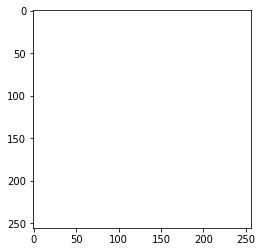

In [ ]:
fig = plt.figure()
camera = Camera(fig)  # create the camera object from celluloid
pred = output_tensor.argmax(0)

for i in range(0, output_tensor.shape[3], 2):  # axial view
    plt.imshow(imgs[0,:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(pred[:,:,i]==0, pred[:,:,i])
    label_mask = np.ma.masked_where(mask[0,:,:,i]==0, mask[0,:,:,i])
    plt.imshow(mask_, alpha=0.1, cmap="autumn")
    #plt.imshow(label_mask, alpha=0.5, cmap="jet")  # Uncomment if you want to see the label

    # plt.axis("off")
    camera.snap()  # Store the current slice
animation = camera.animate()  # create the animation




In [ ]:
HTML(animation.to_html5_video())  # convert the animation to a video


/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:993: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
